In [1]:
import numpy as np 
import pandas as pd 
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')

In [2]:
data=pd.read_csv(r'./ratings_Electronics.csv',names=['userId', 'productId','Rating','timestamp'])
data.shape

(7824482, 4)

In [3]:
data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
#Dropping the Timestamp column
data.drop(['timestamp'], axis=1,inplace=True)

In [5]:
#选择一个子集
# data_subset=data.iloc[:20000,0:]
data_subset=data.iloc[:550000,0:]

In [6]:
#查看数据类型
data_subset.dtypes

userId        object
productId     object
Rating       float64
dtype: object

In [7]:
data_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550000 entries, 0 to 549999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     550000 non-null  object 
 1   productId  550000 non-null  object 
 2   Rating     550000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 12.6+ MB


In [8]:
data_subset.describe()['Rating'].T

count    550000.000000
mean          3.990153
std           1.393335
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64

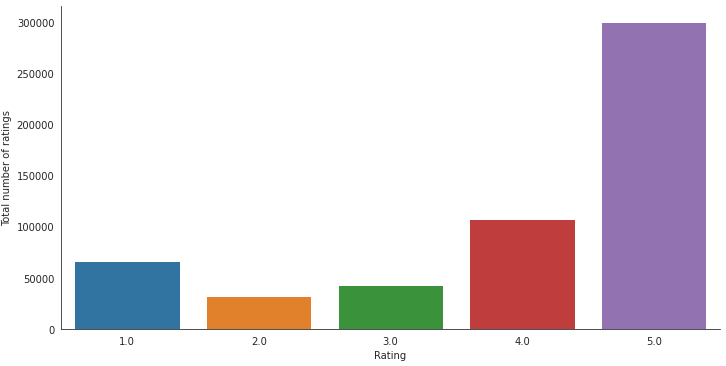

In [9]:
# rating的分布
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=data_subset, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

大多数人都评分为5.0

In [10]:
print("Total data ")
print("-"*50)
print("\nTotal number of ratings :",data_subset.shape[0])
print("Total number of Users   :", len(np.unique(data_subset.userId)))
print("Total number of products  :", len(np.unique(data_subset.productId)))

Total data 
--------------------------------------------------

Total number of ratings : 550000
Total number of Users   : 440914
Total number of products  : 33251


## 分析rating

In [11]:
#分析每个用户评价商品的个数
number_of_rated_products_per_user = data_subset.groupby(by='userId')['Rating'].count().sort_values(ascending=False)
number_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     322
A231WM2Z2JL0U3    248
A25HBO5V8S8SEA    159
AT6CZDCP4TRGA      89
AKT8TGIT6VVZ5      89
Name: Rating, dtype: int64

In [12]:
number_of_rated_products_per_user.describe()

count    440914.000000
mean          1.247409
std           1.220266
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         322.000000
Name: Rating, dtype: float64

In [13]:
quantiles = number_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

<AxesSubplot:title={'center':'Quantiles and their Values'}>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

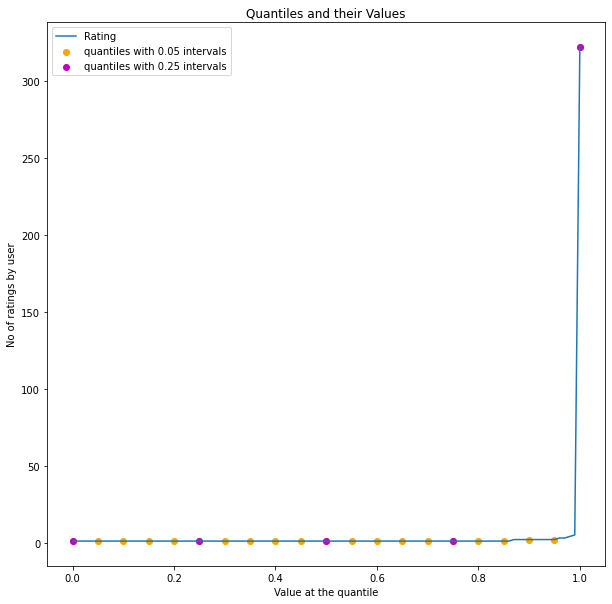

In [14]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [15]:
#计算每个用户给出的所有评分，评级产品个数大于等于50的有38个用户
print('\n Number of rated product more than 50 per user : {}\n'.format(sum(number_of_rated_products_per_user >= 50)) )




 Number of rated product more than 50 per user : 21



### 基于人气的推荐

In [16]:
#Getting the new dataframe which contains users who has given 50 or more ratings
#选择被评级次数大于等于50次的产品（热销产品）
new_df=data_subset.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

In [17]:
#number_of_ratings_per_product存储被评级次数大于50次的产品（热销产品），按照降序排列，
number_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)
number_of_ratings_per_product.head()

productId
B0002L5R78    9487
B0001FTVEK    5345
B00007E7JU    3523
B00007M1TZ    2608
B00004ZCJE    2547
Name: Rating, dtype: int64

In [18]:
#每一种热销产品的平均评级，按平均评级降序排列
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B0002E52S4    4.861111
Name: Rating, dtype: float64

In [19]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
ratings_mean_count.head()
#每个商品的平均评分和被评分的次数

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


,rating_counts
productId,
B0002L5R78,9487
B0001FTVEK,5345
B00007E7JU,3523
B00007M1TZ,2608
B00004ZCJE,2547
...,...
B00006I5JA,50
B00004YKHT,50
B00005ALB1,50


<AxesSubplot:xlabel='productId'>

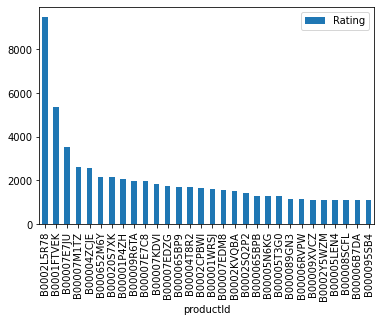

In [20]:
#最受欢迎的产品（排名前10，按照评价等级次数）
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.rename(columns={'Rating':'rating_counts'})
most_popular.head(30).plot(kind = "bar")

In [21]:
most_popular.head(10)

,Rating
productId,
B0002L5R78,9487
B0001FTVEK,5345
B00007E7JU,3523
B00007M1TZ,2608
B00004ZCJE,2547
B000652M6Y,2152
B00020S7XK,2140
B00001P4ZH,2075
B00009R6TA,1978


## 协同过滤（Item-Item recommedation）
#### 协同过滤通常用于推荐系统。这些技术旨在填补用户-项目关联矩阵中缺失的条目。使用协同过滤 (CF) 方法。 CF 的基础是最好的推荐来自具有相似品味的人。换句话说，它使用志同道合的人的历史项目评分来预测某人如何评价一个项目

In [20]:
from surprise import BaselineOnly,KNNWithMeans,KNNBaseline,SVD,SVDpp,NMF,SlopeOne
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate

In [23]:
#new_df存储被评级次数大于等于50次的产品
new_df

,userId,productId,Rating
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0
...,...,...,...
549995,A38X3FWC11WI2W,B00066IJPQ,5.0
549996,A01036691ZFOFCXBLP2D1,B00066IJPQ,5.0
549997,A1ANBQ6YTBWOHS,B00066IJPQ,5.0
549998,APWV9ND2Q1CPX,B00066IJPQ,3.0


In [23]:
#surprise库读取数据集
reader = Reader(rating_scale=(1, 5))
new_data = Dataset.load_from_df(new_df,reader)

In [25]:
# trainset, testset = train_test_split(new_data, test_size=0.3,random_state=10)

In [26]:
# BaselineOnly
cross_validate(BaselineOnly(), new_data, measures=['RMSE', 'MAE','FCP'], cv=3, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE, FCP of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2607  1.2546  1.2611  1.2588  0.0030  
MAE (testset)     0.9897  0.9860  0.9901  0.9886  0.0018  
FCP (testset)     0.5040  0.5148  0.5082  0.5090  0.0044  
Fit time          1.69    1.88    1.98    1.85    0.12    
Test time         1.34    1.26    1.58    1.39    0.14    


{'test_rmse': array([1.26074879, 1.25459374, 1.2611126 ]),
 'test_mae': array([0.98966413, 0.98599732, 0.99006052]),
 'test_fcp': array([0.50400984, 0.51478397, 0.50819072]),
 'fit_time': (1.6882071495056152, 1.8762731552124023, 1.9803111553192139),
 'test_time': (1.3398480415344238, 1.258072853088379, 1.5812790393829346)}

In [27]:
#KNNWithMeans
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson', 'user_based': False})#Cosine, MSD, pearson,pearson_baseline
cross_validate(algo, new_data, measures=['RMSE', 'MAE','FCP'], cv=3, verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE, FCP of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.3391  1.3362  1.3381  1.3378  0.0012  
MAE (testset)     1.0493  1.0482  1.0488  1.0488  0.0004  
FCP (testset)     0.6125  0.6080  0.6084  0.6096  0.0020  
Fit time          0.71    0.89    0.72    0.77    0.08    
Test time         2.08    1.99    1.66    1.91    0.18    


{'test_rmse': array([1.33907058, 1.33616471, 1.33810497]),
 'test_mae': array([1.049298  , 1.04824466, 1.04884526]),
 'test_fcp': array([0.61251104, 0.60800498, 0.60837187]),
 'fit_time': (0.7142431735992432, 0.8938977718353271, 0.7154901027679443),
 'test_time': (2.077605962753296, 1.9884660243988037, 1.6620218753814697)}

In [28]:
#KNNBaseline
algo_KNNBaseline = KNNBaseline(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
cross_validate(algo_KNNBaseline, new_data, measures=['RMSE', 'MAE','FCP'], cv=3, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE, FCP of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2612  1.2594  1.2634  1.2613  0.0016  
MAE (testset)     0.9847  0.9858  0.9887  0.9864  0.0017  
FCP (testset)     0.5128  0.4947  0.5295  0.5123  0.0142  
Fit time          2.17    2.30    2.29    2.26    0.06    
Test time         1.86    1.43    1.86    1.71    0.20    


{'test_rmse': array([1.26120232, 1.25937166, 1.26340358]),
 'test_mae': array([0.98465834, 0.98579488, 0.98865501]),
 'test_fcp': array([0.51276286, 0.49465065, 0.52946344]),
 'fit_time': (2.174482822418213, 2.3043179512023926, 2.2902960777282715),
 'test_time': (1.8559648990631104, 1.4306328296661377, 1.857875108718872)}

In [29]:
#KNNBaseline_sgd
algo_KNNBaseline_sgd = KNNBaseline(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False,'bsl_options':'sgd'})
cross_validate(algo_KNNBaseline_sgd, new_data, measures=['RMSE', 'MAE','FCP'], cv=3, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE, FCP of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2613  1.2603  1.2641  1.2619  0.0016  
MAE (testset)     0.9864  0.9859  0.9875  0.9866  0.0007  
FCP (testset)     0.5160  0.5030  0.5155  0.5115  0.0060  
Fit time          2.12    2.70    2.18    2.33    0.26    
Test time         1.46    1.36    1.33    1.38    0.05    


{'test_rmse': array([1.26131292, 1.26026078, 1.26411535]),
 'test_mae': array([0.98642014, 0.98594395, 0.98754748]),
 'test_fcp': array([0.51599243, 0.5030211 , 0.5154993 ]),
 'fit_time': (2.1173269748687744, 2.6975150108337402, 2.181936025619507),
 'test_time': (1.4582629203796387, 1.3588008880615234, 1.334693193435669)}

In [30]:
#SVD 没有bias
algo_SVD1 = SVD(biased=False)
cross_validate(algo_SVD1, new_data, measures=['RMSE', 'MAE','FCP'], cv=3, verbose=True)

Evaluating RMSE, MAE, FCP of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.8952  1.8961  1.8956  1.8956  0.0004  
MAE (testset)     1.4558  1.4573  1.4565  1.4566  0.0006  
FCP (testset)     0.5576  0.6260  0.5737  0.5858  0.0292  
Fit time          20.09   19.89   20.45   20.15   0.23    
Test time         1.54    1.16    1.06    1.25    0.20    


{'test_rmse': array([1.89520885, 1.89607096, 1.89555558]),
 'test_mae': array([1.45583332, 1.4573093 , 1.45653339]),
 'test_fcp': array([0.5575765 , 0.62603595, 0.57366875]),
 'fit_time': (20.094014883041382, 19.89005994796753, 20.451812028884888),
 'test_time': (1.5389540195465088, 1.1629481315612793, 1.0628650188446045)}

In [31]:
#SVD 
algo_SVD = SVD()
cross_validate(algo_SVD, new_data, measures=['RMSE', 'MAE','FCP'], cv=3, verbose=True)

Evaluating RMSE, MAE, FCP of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2617  1.2639  1.2605  1.2620  0.0014  
MAE (testset)     0.9899  0.9897  0.9878  0.9891  0.0010  
FCP (testset)     0.5183  0.4989  0.5031  0.5068  0.0083  
Fit time          19.43   19.05   19.34   19.27   0.16    
Test time         1.60    1.02    1.10    1.24    0.26    


{'test_rmse': array([1.26171954, 1.26386195, 1.26054726]),
 'test_mae': array([0.98990582, 0.98974868, 0.98777282]),
 'test_fcp': array([0.51827901, 0.49893841, 0.50307851]),
 'fit_time': (19.429353952407837, 19.045230865478516, 19.344338178634644),
 'test_time': (1.6018879413604736, 1.023545265197754, 1.1044411659240723)}

In [32]:
#使用SVD++
algo_svdpp = SVDpp()
cross_validate(algo_svdpp, new_data, measures=['RMSE', 'MAE','FCP'], cv=3, verbose=True)

Evaluating RMSE, MAE, FCP of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2878  1.2892  1.2820  1.2863  0.0031  
MAE (testset)     1.0011  1.0011  0.9960  0.9994  0.0024  
FCP (testset)     0.5003  0.5001  0.5023  0.5009  0.0010  
Fit time          39.00   39.37   38.71   39.03   0.27    
Test time         2.07    2.06    1.43    1.85    0.30    


{'test_rmse': array([1.28775275, 1.28915459, 1.28196995]),
 'test_mae': array([1.00112994, 1.00112839, 0.99596164]),
 'test_fcp': array([0.50026602, 0.50007067, 0.50228878]),
 'fit_time': (39.00228309631348, 39.36823916435242, 38.70520901679993),
 'test_time': (2.06606125831604, 2.064521074295044, 1.4322199821472168)}

In [33]:
#NFM
algo_nmf = NMF()
cross_validate(algo_nmf, new_data, measures=['RMSE', 'MAE','FCP'], cv=3, verbose=True)

Evaluating RMSE, MAE, FCP of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.3942  1.3881  1.3860  1.3894  0.0035  
MAE (testset)     1.0968  1.0910  1.0894  1.0924  0.0032  
FCP (testset)     0.6171  0.5764  0.6149  0.6028  0.0187  
Fit time          40.54   39.96   40.11   40.21   0.25    
Test time         1.15    1.03    1.06    1.08    0.05    


{'test_rmse': array([1.39421684, 1.38808035, 1.3859983 ]),
 'test_mae': array([1.0967694 , 1.09095059, 1.08943985]),
 'test_fcp': array([0.61708462, 0.57644079, 0.61485817]),
 'fit_time': (40.54499578475952, 39.958322286605835, 40.11192011833191),
 'test_time': (1.1490318775177002, 1.0285260677337646, 1.0586817264556885)}

In [34]:
#NFM
algo_nmf = NMF(biased=True)
cross_validate(algo_nmf, new_data, measures=['RMSE', 'MAE','FCP'], cv=3, verbose=True)

Evaluating RMSE, MAE, FCP of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.5553  1.6287  1.6592  1.6144  0.0436  
MAE (testset)     1.2048  1.2588  1.2907  1.2515  0.0355  
FCP (testset)     0.4616  0.4685  0.4934  0.4745  0.0136  
Fit time          40.98   39.64   40.94   40.52   0.62    
Test time         1.16    1.03    1.07    1.09    0.05    


{'test_rmse': array([1.55534929, 1.6286831 , 1.65920256]),
 'test_mae': array([1.20483111, 1.25880596, 1.29073496]),
 'test_fcp': array([0.46162949, 0.46851823, 0.49335645]),
 'fit_time': (40.97510623931885, 39.63896083831787, 40.936081886291504),
 'test_time': (1.160050868988037, 1.0316228866577148, 1.072145938873291)}

In [24]:
#Slope One算法是基于不同物品之间的评分差的线性算法，预测用户对物品评分的个性化算法
algo_slope = SlopeOne()
cross_validate(algo_slope, new_data, measures=['RMSE', 'MAE','FCP'], cv=3, verbose=True)

Evaluating RMSE, MAE, FCP of algorithm SlopeOne on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.3884  1.3905  1.3916  1.3901  0.0013  
MAE (testset)     1.0567  1.0600  1.0592  1.0586  0.0014  
FCP (testset)     0.6686  0.6710  0.6538  0.6645  0.0076  
Fit time          4.59    4.63    4.63    4.62    0.02    
Test time         1.52    1.47    1.47    1.49    0.02    


{'test_rmse': array([1.38836122, 1.39048545, 1.39157972]),
 'test_mae': array([1.05668327, 1.06000855, 1.05924653]),
 'test_fcp': array([0.6685796 , 0.67101089, 0.65379038]),
 'fit_time': (4.590459823608398, 4.631494045257568, 4.628736734390259),
 'test_time': (1.5210061073303223, 1.4731693267822266, 1.4745688438415527)}

## 基于模型的协同过滤系统
#### 这些方法基于机器学习和数据挖掘技术。目标是训练模型以进行预测。例如，我们可以使用现有的用户-项目交互来训练模型来预测用户可能最喜欢的前 5 个项目。这些方法的一个优点是，与其他方法（如基于内存的方法）相比，它们能够向更多用户推荐更多项目。即使在处理大型稀疏矩阵时，它们也具有很大的覆盖范围。

In [35]:
#获得user-iterm矩阵
new_df1=new_df
ratings_matrix = new_df1.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()
#用0来补全空缺值，并不是每个人都有买每一个产品

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B0006698SS,B000669BVW,B00066D1GI,B00066EK2W,B00066EK36,B00066EK3G,B00066EK40,B00066FH1U,B00066FHHO,B00066IJPQ
userId,,,,,,,,,,,,,,,,,,,,,
A0004478EF5NFPHLGCWG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A000681618A3WRMCK53V,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A00124802J36AVPT3779A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0015232111B3971DPSKF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A00328742CDZTXNDCB9XW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
ratings_matrix.shape

(301087, 1961)

In [37]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
X = ratings_matrix.T
svd = TruncatedSVD(n_components=10)#降维，截断的奇异值分解
decomposed_matrix = svd.fit_transform(X)
decomposed_matrix.shape

(1961, 10)

In [38]:
#iterm特征的相关矩阵
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix

array([[ 1.        ,  0.02033667, -0.04787897, ..., -0.38803631,
        -0.46863445,  0.56817485],
       [ 0.02033667,  1.        , -0.16196677, ..., -0.36263225,
        -0.09253768,  0.33016837],
       [-0.04787897, -0.16196677,  1.        , ...,  0.38514449,
        -0.06280079, -0.09887196],
       ...,
       [-0.38803631, -0.36263225,  0.38514449, ...,  1.        ,
         0.00625347, -0.25478667],
       [-0.46863445, -0.09253768, -0.06280079, ...,  0.00625347,
         1.        , -0.28040739],
       [ 0.56817485,  0.33016837, -0.09887196, ..., -0.25478667,
        -0.28040739,  1.        ]])

In [39]:
i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)

In [40]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID

array([-0.02859401,  0.12152155,  0.79610529, ...,  0.32028364,
       -0.00460775, -0.03143566])

In [41]:
#Recommend存放和商品B00000K135相关系数大于0.65的其他商品ID
Recommend = list(X.index[correlation_product_ID > 0.65])
# Removes the item already bought by the customer
Recommend.remove(i) 
Recommend[0:10]

['1400501520',
 '9575871979',
 '9983891212',
 'B00000IGBF',
 'B00000J1EQ',
 'B00000J434',
 'B00000J4FS',
 'B00000JMUG',
 'B00001ZT4H',
 'B000021YUO']

In [42]:
#KNNBaseline推荐10个商品
# sim_options = {'name': 'pearson_baseline', 'user_based': False}
# algo_KNNBaseline = KNNBaseline(sim_options=sim_options)
new_df2=data.iloc[560000:562000,:]
new_df2=new_df2.groupby("productId").filter(lambda x:x['Rating'].count() >=50)
new_testdata=Dataset.load_from_df(new_df2,reader)
trainset = new_testdata.build_full_trainset()
# algo_KNNBaseline.fit(trainset)
pro_id = "B00000K135"
pro_inner_id = algo_KNNBaseline.trainset.to_inner_iid(pro_id)#指定商品的index

# Retrieve inner ids of the nearest neighbors of "B00000K135".
pro_neighbors = algo_KNNBaseline.get_neighbors(pro_inner_id, k=10)
Recommend_KNNBaseline = list(X.index[pro_neighbors])
Recommend_KNNBaseline

['B00008L3HY',
 '0972683275',
 '1400501466',
 '1400501520',
 '1400501776',
 '1400532620',
 '1400532655',
 '140053271X',
 '1400532736',
 '1400599997']

In [43]:
#SVD为用户'A1ISUNUWG0K02V'推荐打分最高的10个商品
#选择要推荐的商品集
new_df2=data.iloc[560000:562000,:]
test_iids=new_df2['productId'].tolist()
test_iids=np.unique(test_iids)
uid='A1ISUNUWG0K02V'
preds=np.zeros((len(test_iids),))
for i in range(len(test_iids)):
    pred = algo_SVD.predict(uid, test_iids[i])#通过uid，和iid预测用户评分
    preds[i]=pred.est

testset=np.vstack((test_iids,preds)).T
re_testset=pd.DataFrame(testset,columns=['productId','pre_Rating'])#商品id和预测的评分生成一个dataframe
#推荐打分最高的前10个商品
top_n=re_testset.sort_values(by="pre_Rating" , ascending=False) 
top_n.head(10)

,productId,pre_Rating
0,B0006B486K,3.999057994663528
74,B0006BKJFY,3.999057994663528
72,B0006BKH3S,3.999057994663528
71,B0006BKGB6,3.999057994663528
70,B0006BKGAW,3.999057994663528
69,B0006BKG9I,3.999057994663528
68,B0006BKG98,3.999057994663528
67,B0006BKDQE,3.999057994663528
66,B0006BK9ZE,3.999057994663528
65,B0006BK50I,3.999057994663528
